<a href="https://colab.research.google.com/github/JuShiCode/JuShiCode/blob/main/%D0%A1%D0%B1%D0%BE%D1%80_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%B8_%D0%BF%D0%B0%D1%80%D1%81%D0%B8%D0%BD%D0%B3_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Сбор изображений для решения задач классификации

##Загрузка библиотек

In [1]:
import matplotlib.pyplot as plt # отображение изображений и графиков
import random # использование случайных значений
import requests # библиотека для отправки запросов в Интернет
from bs4 import BeautifulSoup # библиотека для обработки полученных данных
import os # библиотека для работы с файлами и папками
from tqdm import tqdm # библиотека для отображения прогресса в цикле
import urllib.request # библиотка для скачивания изображений
import pprint

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization #Базовые слои для счёрточных сетей
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator # работа с изображениями
from tensorflow.keras.models import Sequential #Сеть прямого распространения
from tensorflow.keras.preprocessing import image # считывание изображений
from tensorflow.keras.optimizers import Adam # оптимизатор

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Сбор изображений

### Сбор информации

In [3]:
link_root = 'http://www.motorpage.ru' #сайт

r = requests.get(link_root + '/media/photos.html') #информация о галерее изображений
soup = BeautifulSoup(r.text) # создание объекта для обработки текста страницы

In [4]:
car_cards = soup.findAll('a', {'class': "col-xs-12 col-sm-6 zero-padding"}) #информация о "карточках" всех марок

In [5]:
car_cards[:10]

[<a class="col-xs-12 col-sm-6 zero-padding" href="/Acura/photos.html"> <figure> <img alt="Фото машин Acura" src="http://cdn.motorpage.ru/Photos/300/240A1.jpg"/> <figcaption class="caption-photos">365</figcaption> </figure> <div> <div> <img alt="Логотип Acura" src="http://cdn.motorpage.ru/AutoLogoMid/Acura_1.jpg"/> <h3>Acura</h3> <p class="hidden visible-md visible-lg">Моделей: 7</p> </div> </div> </a>,
 <a class="col-xs-12 col-sm-6 zero-padding" href="/AlfaRomeo/photos.html"> <figure> <img alt="Фото машин Alfa Romeo" src="http://cdn.motorpage.ru/Photos/300/Giulietta_11.jpg"/> <figcaption class="caption-photos">241</figcaption> </figure> <div> <div> <img alt="Логотип Alfa Romeo" src="http://cdn.motorpage.ru/AutoLogoMid/Alfa_Romeo_1.jpg"/> <h3>Alfa Romeo</h3> <p class="hidden visible-md visible-lg">Моделей: 15</p> </div> </div> </a>,
 <a class="col-xs-12 col-sm-6 zero-padding" href="/Alpina/photos.html"> <div> <div> <img alt="Логотип Alpina" src="http://cdn.motorpage.ru/AutoLogoMid/Alpin

In [6]:
brand_links = [card['href'] for card in car_cards] #конец ссылки для каждого бренда
brand_names = [link[1:link.rfind('/')].capitalize() for link in brand_links] #имя каждого бренда

brand_dict = {k:v for k, v in zip(brand_names, brand_links)} #словарь, в котором каждому названия бренда сопоставлена ссылка на страницу с фотографиями

In [7]:
number_cards = soup.findAll('figcaption', {'class': "caption-photos"}) #карточка с числом для каждой карточки марки

In [8]:
card_values = [int(card.text) for card in number_cards] #текст с каждой карточки и преобразование в число

brand_numbers = list(zip(brand_names, card_values)) #создание пар (имя бренда, количество фото)
brand_numbers.sort(key = lambda x: x[1], reverse = True) #сортировка пар по количеству фото в обратном порядке

In [9]:
brands_to_consider = 3 # количество брендов, которые будут рассмотрены при решении задачи
interesting_brands_info = brand_numbers[:brands_to_consider] #отбрасываем лишние бренды

In [10]:
for brand_name, pic_num in interesting_brands_info: #проходим по списку с парами значений
    print(f'Для бренда {brand_name} присутствует {pic_num} изображений') #выводим информацию о марках

Для бренда Mercedesbenz присутствует 3077 изображений
Для бренда Kia присутствует 2889 изображений
Для бренда Audi присутствует 2670 изображений


In [11]:
considered_brands = [brand_name for brand_name, pic_num in interesting_brands_info] # выбор названий только интересных нам брэндов

### Сбор изображений

In [12]:
data_path = './train_data/' #путь к данным
os.makedirs(data_path, exist_ok=True) #создаем папку для данных, если её не существует

In [13]:
link_dict = {} #словарь {бренд:список ссылок на фото}

for brand_name in considered_brands: #проходим по рассматриваемым брендам
    os.makedirs(data_path + brand_name, exist_ok=True) #создаём папку бренда, если её не существует
    
    current_link = link_root + brand_dict[brand_name] # создаём текущую ссылку с помощью ранее созданного словаря
    r = requests.get(current_link) #информация об изображениях модели
    soup = BeautifulSoup(r.text) #объект для обработки информации
    
    model_cards = soup.findAll('a', {'class': "col-xs-12 col-sm-4 col-md-3"}) #информация о карточках моделей
    model_links = [model_card['href'] for model_card in model_cards] #ссылка для изображений каждой модели
    brand_links = [] #хранилище для ссылок на изображения машин данного бренда

    for model_link in tqdm(model_links): #проходим по всем ссылкам на изображения с моделями

        direct_link = link_root + model_link
        r = requests.get(direct_link) #информация о сайте с изображениями
        soup = BeautifulSoup(r.text) # бъект для поиска ссылок на изображения
        picture_frames = soup.findAll('img', {'title': True}) # информация о "больших изображениях" на страницах моделей
        picture_links = [frame['src'] for frame in picture_frames] # информация о ссылках на исходные изображения
        brand_links += picture_links # добавляем ссылки для данной модели в общий пул ссылок по бренду

    link_dict[brand_name] = brand_links # информация о ссылках для данного бренда

100%|██████████| 49/49 [00:45<00:00,  1.08it/s]


In [14]:
for brand_name, link_list in link_dict.items(): # разбираем словарь на название бренда и список ссылок на изображения
    dir_path = data_path + brand_name # текущая директория для сохранения изображений
    for idx, link in enumerate(tqdm(link_list)): #проходим по списку ссылок, сохраняя номер итерации
        urllib.request.urlretrieve(link, f"{dir_path}/{idx}.jpg") # сохраняем изображения

100%|██████████| 1106/1106 [27:41<00:00,  1.50s/it]


#### Сохранение сгенерированных данных в zip archive 

In [18]:
!zip -r "car_data.zip" './train_data/'

  adding: train_data/ (stored 0%)
  adding: train_data/Mercedesbenz/ (stored 0%)
  adding: train_data/Mercedesbenz/114.jpg (deflated 0%)
  adding: train_data/Mercedesbenz/315.jpg (deflated 6%)
  adding: train_data/Mercedesbenz/651.jpg (deflated 0%)
  adding: train_data/Mercedesbenz/1037.jpg (deflated 0%)
  adding: train_data/Mercedesbenz/1127.jpg (deflated 0%)
  adding: train_data/Mercedesbenz/366.jpg (deflated 1%)
  adding: train_data/Mercedesbenz/771.jpg (deflated 0%)
  adding: train_data/Mercedesbenz/762.jpg (deflated 0%)
  adding: train_data/Mercedesbenz/1427.jpg (deflated 0%)
  adding: train_data/Mercedesbenz/221.jpg (deflated 0%)
  adding: train_data/Mercedesbenz/743.jpg (deflated 1%)
  adding: train_data/Mercedesbenz/840.jpg (deflated 0%)
  adding: train_data/Mercedesbenz/852.jpg (deflated 1%)
  adding: train_data/Mercedesbenz/1137.jpg (deflated 0%)
  adding: train_data/Mercedesbenz/693.jpg (deflated 1%)
  adding: train_data/Mercedesbenz/860.jpg (deflated 0%)
  adding: train_dat

#### Скачивание данных из Google Drive

In [ ]:
!unzip '/content/drive/MyDrive/Базы/car_parse.zip' -d './train_data/'

Archive:  /content/drive/MyDrive/Занятия/Июльский курс/Доп семинары/car_parse.zip
   creating: ./train_data/car_data/
   creating: ./train_data/car_data/Audi/
  inflating: ./train_data/car_data/Audi/0.jpg  
  inflating: ./train_data/car_data/Audi/1.jpg  
  inflating: ./train_data/car_data/Audi/10.jpg  
  inflating: ./train_data/car_data/Audi/100.jpg  
  inflating: ./train_data/car_data/Audi/1000.jpg  
  inflating: ./train_data/car_data/Audi/1001.jpg  
  inflating: ./train_data/car_data/Audi/1002.jpg  
  inflating: ./train_data/car_data/Audi/1003.jpg  
  inflating: ./train_data/car_data/Audi/1004.jpg  
  inflating: ./train_data/car_data/Audi/1005.jpg  
  inflating: ./train_data/car_data/Audi/1006.jpg  
  inflating: ./train_data/car_data/Audi/1007.jpg  
  inflating: ./train_data/car_data/Audi/1008.jpg  
  inflating: ./train_data/car_data/Audi/1009.jpg  
  inflating: ./train_data/car_data/Audi/101.jpg  
  inflating: ./train_data/car_data/Audi/1010.jpg  
  inflating: ./train_data/car_data

## Нейронная сеть

In [ ]:
#Базовые слои для счёрточных сетей
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator # работа с изображениями
from tensorflow.keras.models import Sequential #Сеть прямого распространения
from tensorflow.keras.preprocessing import image # считывание изображений
from tensorflow.keras.optimizers import Adam # оптимизатор
import matplotlib.pyplot as plt # отображение изображений и графиков
import random # использование случайных значений

In [19]:
train_path = './train_data/' # Папка с данными, находящимися в разных папками
batch_size = 32 # Размер выборки
img_width = 192 # Ширина изображения 
img_height = 128 # Высота изображения 

In [20]:
# Генератор изображений
datagen = ImageDataGenerator(
    rescale=1. / 255, # Значения цвета меняем на дробные показания
    rotation_range=20, # Поворачиваем изображения при генерации выборки
    width_shift_range=0.2, # Двигаем изображения по ширине при генерации выборки
    height_shift_range=0.2, # Двигаем изображения по высоте при генерации выборки
    zoom_range=0.2, # Зумируем изображения при генерации выборки
    horizontal_flip=True, # Отзеркаливание изображений
    fill_mode='nearest', # Заполнение пикселей вне границ ввода
    validation_split=0.2) # Указываем разделение изображений на обучающую и тестовую выборку

In [21]:
# Обучающая выборка
train_generator = datagen.flow_from_directory(
    train_path, # Путь ко всей выборке выборке
    target_size=(img_width, img_height), # Размер изображений
    batch_size=batch_size, # Размер batch_size
    class_mode='categorical', # Категориальный тип выборки. Разбиение выборки по маркам авто 
    shuffle=True, # Перемешивание выборки
    subset='training') # Устанавливаем как набор для обучения

# Проверочная выборка
validation_generator = datagen.flow_from_directory(
    train_path, # Путь ко всей выборке выборке
    target_size=(img_width, img_height), # Размер изображений
    batch_size=batch_size, # Размер batch_size
    class_mode='categorical', # Категориальный тип выборки. Разбиение выборки по маркам авто 
    shuffle=True, # Перемешивание выборки
    subset='validation') # Устанавливаем как валидационный набор

Found 3119 images belonging to 3 classes.
Found 779 images belonging to 3 classes.


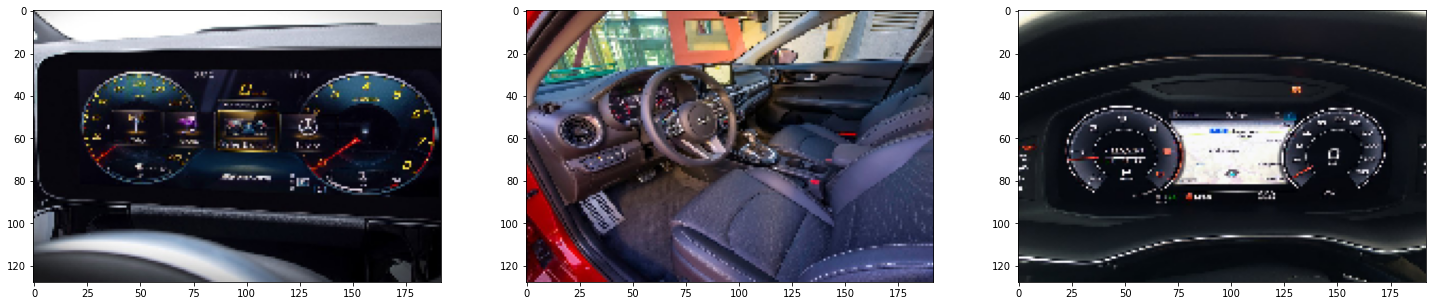

In [22]:
# Вывод изображений из каждого класса

fig, axs = plt.subplots(1, 3, figsize=(25, 5)) # Создание ряда из трёх изображений
for i in range(3): #проходим по классам
  car_path = train_path + '/' + os.listdir(train_path)[i] + '/'# Формируем путь к выборке
  img_path = car_path + random.choice(os.listdir(car_path)) # Выбираем случайное фото для отображения
  axs[i].imshow(image.load_img(img_path, target_size=(img_height, img_width))) # Отображение фотографии

plt.show() # Показываем изображения

In [ ]:
model = Sequential()

# 1
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', activation='relu', input_shape=(img_width, img_height, 3)))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3))) # Укажем pool_size=(3, 3) - 81*54
model.add(Dropout(0.3))

# 2
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3))) # 27*18
model.add(Dropout(0.3))

# 3
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3))) # 9*6
model.add(Dropout(0.3))

# 4
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3))) # 3*2
model.add(Dropout(0.3))

# 5
model.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
model.add(Dropout(0.3))


model.add(Flatten())
model.add(Dense(2048, activation='elu'))
model.add(Dense(4096, activation='elu'))

# Выходной полносвязный слой
model.add(Dense(len(train_generator.class_indices), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

Epoch 1/60
95/95 [==============================] - 66s 699ms/step - loss: 1.1058 - accuracy: 0.3845 - val_loss: 1.1545 - val_accuracy: 0.3071
Epoch 2/60
95/95 [==============================] - 65s 684ms/step - loss: 1.0904 - accuracy: 0.3931 - val_loss: 1.1239 - val_accuracy: 0.3193
Epoch 3/60
95/95 [==============================] - 66s 697ms/step - loss: 1.0742 - accuracy: 0.4238 - val_loss: 1.2396 - val_accuracy: 0.3071
Epoch 4/60
95/95 [==============================] - 65s 686ms/step - loss: 1.0579 - accuracy: 0.4512 - val_loss: 1.1140 - val_accuracy: 0.3234
Epoch 5/60
95/95 [==============================] - 65s 685ms/step - loss: 1.0258 - accuracy: 0.4922 - val_loss: 1.1287 - val_accuracy: 0.3736
Epoch 6/60
95/95 [==============================] - 66s 691ms/step - loss: 1.0024 - accuracy: 0.4876 - val_loss: 1.1803 - val_accuracy: 0.4538
Epoch 7/60
95/95 [==============================] - 65s 688ms/step - loss: 0.9962 - accuracy: 0.5088 - val_loss: 1.1491 - val_accuracy: 0.4226

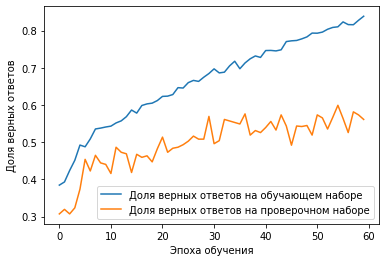

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs=60,
    verbose=1)

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Epoch 1/60
95/95 [==============================] - 65s 687ms/step - loss: 0.3688 - accuracy: 0.8476 - val_loss: 1.3842 - val_accuracy: 0.5788
Epoch 2/60
95/95 [==============================] - 65s 681ms/step - loss: 0.3406 - accuracy: 0.8655 - val_loss: 1.3483 - val_accuracy: 0.5842
Epoch 3/60
95/95 [==============================] - 64s 679ms/step - loss: 0.3155 - accuracy: 0.8724 - val_loss: 1.3627 - val_accuracy: 0.5951
Epoch 4/60
95/95 [==============================] - 65s 680ms/step - loss: 0.3111 - accuracy: 0.8724 - val_loss: 1.4384 - val_accuracy: 0.5883
Epoch 5/60
95/95 [==============================] - 64s 678ms/step - loss: 0.2877 - accuracy: 0.8889 - val_loss: 1.4701 - val_accuracy: 0.5815
Epoch 6/60
95/95 [==============================] - 64s 676ms/step - loss: 0.3053 - accuracy: 0.8767 - val_loss: 1.4736 - val_accuracy: 0.5842
Epoch 7/60
95/95 [==============================] - 64s 676ms/step - loss: 0.2895 - accuracy: 0.8840 - val_loss: 1.5588 - val_accuracy: 0.5842

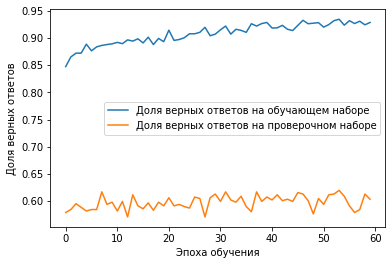

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs=60,
    verbose=1)


plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# Сбор текстовых данных для решения задачи классификации

##Загрузка библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #библиотека для визуализации данных
# "Магическая"команда python для запуска библиотеки в ноутбуке
%matplotlib inline

from tensorflow.keras import utils #модуль с утилитами кераса, будем использовать для вызова метода преобразования категорий в вектора
from tensorflow.keras.models import Sequential #последовательная модель нейросети кераса
# Загружаем стандартные слои нейросети(полносвязный, регуляризации, нормализации, векторного представления слов, выравнивания, активации)
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
# Загружаем сверточные слои
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
# Загружаем рекуррентные слои
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
# Загружаем алгоритмы обучения/оптимизации
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence #инструменты предобработки текста от кераса
from sklearn.model_selection import train_test_split #модуль для разбиения данных на обучающую и тестовую выборки

##Сбор информации с сайта

In [ ]:
root_link = 'https://youla.ru' # главная страница сайта
postfixes = { # словарь 'название категории': 'конец ссылки'
    'Услуги исполнителей': 'uslugi',
    'Заявки на услуги': 'zayavki',
    'Недвижимость': 'nedvijimost',
    'Животные': 'zhivotnye',
    'Спецтехника и мотоциклы': 'spetstehnika-moto',
    'Запчасти и автотовары': 'avto-moto',
    'Вакансии': 'rabota',
    'Для бизнеса': 'dlya-biznesa'
}

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
pages_to_parse = 10 # количество страниц из каждой категории, объявления с которых будут обработаны
texts_dict = {} # создание словаря со ссылками на предложения

for name, link in postfixes.items():
    texts_dict[name] = [] # создаём список ссылок на посты данной категории
    for p in tqdm(range(pages_to_parse)): # итерируемся по страницам 
        r = requests.get(root_link + '/all/' + link, {'p': p}) # поиск по всем предложениям в данной категории на данной странице
        soup = BeautifulSoup(r.text) # создание парсера информации
        headers = soup.findAll('div', {'class': "product_item__title"}) # находим все контейнеры с названиями услуг
        header_texts = [header.text for header in headers] # получаем заголовки всех постов на странице
        texts_dict[name] += header_texts # добавляем найденные на странице заголовки к заголовкам данной категории

In [ ]:
df_ = pd.DataFrame(texts_dict)
df_

,Услуги исполнителей,Заявки на услуги,Недвижимость,Животные,Спецтехника и мотоциклы,Запчасти и автотовары,Вакансии,Для бизнеса
0,Вывоз строителного мусора,Репетитор по английскому языку можно по скайпу,"Квартира, 2 комнаты, 45 м²","Сибирская, стерильна с паспортом, привита.Крыс...",Электропогрузчик,Диски оригинальные Рено r17 на летней резине,Требуется водитель-экспедитор,"вывеска конструктор, объемные буквы"
1,Мебель из бочек,требуется услуга технолога по деревообработке,"Квартира, 2 комнаты, 70 м²",Среднеазиацкая овчарка,RENAULT MASTER 3,Комплект болеро для Шкода карок,Сантехник,Дистрибуция каменной ваты
2,Наращивание ресниц. Обучение. Москворечье-Сабу...,Сниму комнату от метро 5 -10 мин можно пустую,"Квартира, 3 комнаты, 58 м²",Щенуля Чернушка(Блэки) в дар,Услуги экскаватора погрузчика,Колёса в сборе.,Почтальон,Гостиница для кошек. Прибыль 148 т.р. в месяц
3,Регистрация ООО под ключ с ЭЦП за 20 минут,Куплю утку домашнюю,"Дом, 205 м²",Кошка,Аренда экскаватора погрузчика,13,ШВЕЯ,Генератор этилена каталитического типа genet б/у
4,Изготовление гос номеров,Уборка,"Коттедж, 300 м²",Парочка красавцев,"Ассенизатор , откачка",Подсветка в двери с логотипом (На все модели),водитель такси,Швейное производство
...,...,...,...,...,...,...,...,...
595,Бухгалтерские услуги,Забор товара,"Гараж, аренда",Щенки малинуа,Аренда автовышки АГП Зеленоград,Зимняя резина TOYO 225/60 R18,Мастер маникюра,Бокс полировки зуботехнический ювелирный
596,Предлагаем услуги по уборке квартир,Уборка дома,"Коттедж, 70 м²",Бенгальские котята (метисы),Мопед РИГА.сиденье Рига 11—13,Автобокс MaxBoxPro 400 белый глянец двухсторонний,Курьер,Готовый бизнес для нейл мастера
597,"Переезды, перевозки, доставка.",Наберу баллы НМО,"Коттедж, 450 м²",Продается британский котенок,Honda X4,"Отопитель воздушный, фен, автономка",Разнорабочий,Вытяжная система для лазерного станка Trotec
598,"Переезд. Грузчики. Перевозка мебели, пианино, ...",Вазьму заказы на ремонт окон,"Квартира, 2 комнаты, 46 м²",Котенок Люси,Альфа 2,RЕNАULТ ЕSPАCЕ IV Рэно Дверь правая левая,ОХРАННИК-КОНТРОЛЛЕР,Доска маркерная- настенная 170х100 см


In [ ]:
dataFrame_list = [] # создаём временный список для сохранения датафреймов
for name, texts in texts_dict.items():
    temporal_dataFrame = pd.DataFrame(data = texts, columns=['Текст заголовка']) # создание датафрейма с текстами заголовков
    temporal_dataFrame['Категория'] = name # добавление информации о категории
    dataFrame_list.append(temporal_dataFrame) # сохранение датафрейма в список

data = pd.concat(dataFrame_list, ignore_index = True) # объединяем датафреймы, "сбрасывая" индексы

In [ ]:
# data.to_csv('/content/drive/MyDrive/Базы/youla_headers.csv', index=None)

In [ ]:
df = pd.read_csv('/content/drive/Базы/youla_headers.csv')
df

,Текст заголовка,Категория
0,Механизированная стяжка пола за 1 день,Услуги исполнителей
1,Грузоперевозки,Услуги исполнителей
2,Торты на заказ,Услуги исполнителей
3,"Удаление нежелательных запахов, вирусов и бакт...",Услуги исполнителей
4,Ремонт строительного инструмента Одинцовский р...,Услуги исполнителей
...,...,...
47995,Вывеска.,Для бизнеса
47996,Пресс мембранно-вакуумный ПО 2500,Для бизнеса
47997,КАБИНЕТ РУКОВОДИТЕЛЯ,Для бизнеса
47998,"Зеркало + рабочий стол стилиста "" винтаж """,Для бизнеса


In [ ]:
labels = LabelEncoder()
labels.fit(df['Категория'])
labels.classes_

array(['Вакансии', 'Для бизнеса', 'Животные', 'Запчасти и автотовары',
       'Заявки на услуги', 'Недвижимость', 'Спецтехника и мотоциклы',
       'Услуги исполнителей'], dtype=object)

In [ ]:
df['classes'] = labels.transform(df['Категория'])
df

,Текст заголовка,Категория,classes
0,Механизированная стяжка пола за 1 день,Услуги исполнителей,7
1,Грузоперевозки,Услуги исполнителей,7
2,Торты на заказ,Услуги исполнителей,7
3,"Удаление нежелательных запахов, вирусов и бакт...",Услуги исполнителей,7
4,Ремонт строительного инструмента Одинцовский р...,Услуги исполнителей,7
...,...,...,...
47995,Вывеска.,Для бизнеса,1
47996,Пресс мембранно-вакуумный ПО 2500,Для бизнеса,1
47997,КАБИНЕТ РУКОВОДИТЕЛЯ,Для бизнеса,1
47998,"Зеркало + рабочий стол стилиста "" винтаж """,Для бизнеса,1


In [ ]:
df.isna().sum()

Текст заголовка    0
Категория          0
classes            0
dtype: int64

##Формирование выборок

In [ ]:
nuw_word_counts =2204
tokenizer = Tokenizer(nuw_word_counts,  filters='', oov_token='unk')

In [ ]:
tokenizer.fit_on_texts(df['Текст заголовка'])

In [ ]:
len(tokenizer.index_word)

2205

In [ ]:
x_train_text = []
y_train = []

for i in df.to_numpy():
    x_train_text.append(i[0])
    y_train.append(i[2])

In [ ]:
x_train = tokenizer.texts_to_sequences(x_train_text)
x_train[:10]

[[864, 1389, 1600, 733, 19, 1601],
 [278],
 [796, 3, 879],
 [1431, 1664, 1665, 1666, 8, 1667],
 [45, 1732, 1733, 846, 865],
 [69, 14, 1767, 52, 1768],
 [111, 3, 1529, 1769, 269, 1448],
 [14, 69, 1770, 52, 1771],
 [14, 69, 262, 1772],
 [59, 174]]

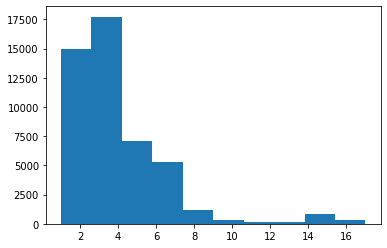

In [ ]:
plt.hist([len(i) for i in x_train])
plt.show()

In [ ]:
x_len = 7
X_train_pad = pad_sequences(x_train, x_len)
X_train01 = tokenizer.texts_to_matrix(x_train_text)
Y_train = utils.to_categorical(np.array(y_train), 8)

In [ ]:
ind = [len(i) < 10  for i in x_train]

In [ ]:
x = X_train_pad[ind]
y = np.array(y_train)[ind]

In [ ]:
X_train_pad.shape, x.shape, y.shape

((48000, 7), (45045, 7), (45045,))

##Нейронная сеть

Epoch 1/10
1200/1200 [==============================] - 9s 4ms/step - loss: 1.0520 - accuracy: 0.7441 - val_loss: 11.7495 - val_accuracy: 0.3688
Epoch 2/10
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0243 - accuracy: 0.9917 - val_loss: 12.6114 - val_accuracy: 0.3688
Epoch 3/10
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0186 - accuracy: 0.9936 - val_loss: 12.9549 - val_accuracy: 0.3688
Epoch 4/10
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0163 - accuracy: 0.9937 - val_loss: 13.5958 - val_accuracy: 0.3625
Epoch 5/10
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0174 - accuracy: 0.9931 - val_loss: 13.4210 - val_accuracy: 0.3688
Epoch 6/10
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0177 - accuracy: 0.9935 - val_loss: 14.0659 - val_accuracy: 0.3625
Epoch 7/10
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0166 - accuracy: 0.9937 - val_loss: 14.9270 - val_ac

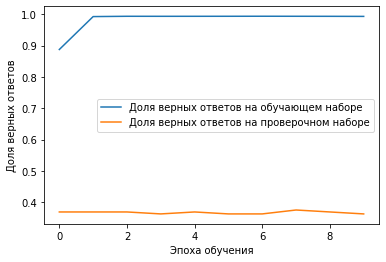

In [ ]:
modelEL = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEL.add(Embedding(nuw_word_counts, 20, input_length=x_len))

# modelEL.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
# modelEL.add(BatchNormalization()) # добавляем слой нормализации данных
modelEL.add(Conv1D(10, 3, padding='same', activation='relu'))
modelEL.add(Flatten())
modelEL.add(Dense(8, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEL.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEL.fit(X_train_pad, 
                    Y_train, 
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Epoch 1/10
1200/1200 [==============================] - 4s 3ms/step - loss: 1.4270 - accuracy: 0.6409 - val_loss: 4.6088 - val_accuracy: 0.2688
Epoch 2/10
1200/1200 [==============================] - 3s 3ms/step - loss: 0.2835 - accuracy: 0.9285 - val_loss: 6.6903 - val_accuracy: 0.3625
Epoch 3/10
1200/1200 [==============================] - 3s 3ms/step - loss: 0.1291 - accuracy: 0.9588 - val_loss: 8.0531 - val_accuracy: 0.3625
Epoch 4/10
1200/1200 [==============================] - 3s 3ms/step - loss: 0.0876 - accuracy: 0.9693 - val_loss: 9.0426 - val_accuracy: 0.3625
Epoch 5/10
1200/1200 [==============================] - 3s 3ms/step - loss: 0.0739 - accuracy: 0.9739 - val_loss: 9.7897 - val_accuracy: 0.3625
Epoch 6/10
1200/1200 [==============================] - 3s 3ms/step - loss: 0.0642 - accuracy: 0.9769 - val_loss: 10.2811 - val_accuracy: 0.3625
Epoch 7/10
1200/1200 [==============================] - 3s 3ms/step - loss: 0.0653 - accuracy: 0.9748 - val_loss: 10.6070 - val_accurac

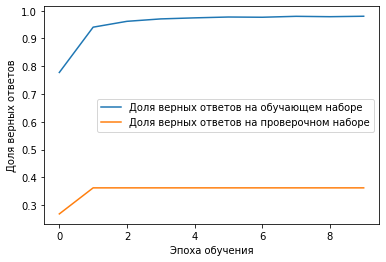

In [ ]:
modelEL = Sequential() # создаём последовательную модель нейросети

modelEL.add(Dense(10, activation='relu')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое
modelEL.add(Dropout(0.2))
# modelEL.add(Dense(1000, activation='relu')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое
# modelEL.add(Dense(200, activation='relu')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое
modelEL.add(Dense(8, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое


# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEL.compile(optimizer=RMSprop(lr=1e-3), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEL.fit(X_train01, 
                    Y_train, 
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()